In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from myfun.try_gpu import *
from myfun.setup_seed import *
from myfun.create_dataset import *
from myfun.evaluation import *
from model.tcn import TCN

np.set_printoptions(threshold=np.inf)

In [2]:
data = pd.read_csv('dataset/B0005.csv')
ts = data['Capacity'].tolist()
Cy = data['Cycles'].tolist()

In [3]:
def train(model_params, look_back=16, lr=0.001, EPOCH=1000, seed=0, train_size=15):
    dataX, dataY = create_dataset(ts, look_back)

    test_size = len(dataX) - train_size
    train_x = torch.from_numpy(dataX[:train_size]).reshape(train_size,look_back,1)
    train_y = torch.from_numpy(dataY[:train_size])
    test_x = torch.from_numpy(dataX[train_size:]).reshape(test_size,look_back,1)
    test_y = torch.from_numpy(dataY[train_size:])
    print(train_x.shape)

    setup_seed(seed)
    model = TCN(**model_params)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    score_list = []
    t_x = test_x.clone()
    loss_list = [0]
    mae, mse, rmse, r2 = 1, 1, 1, 1
    score_, score = 1,1
    for epoch in range(EPOCH):
        model.train()
        train_x = train_x.to(torch.float32).to(device)
        train_y = train_y.to(torch.float32).reshape(train_size, -1).to(device)
    
        out = model(train_x)
        loss = criterion(out, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1)%100 == 0:     #每100次重新预测一次
            model.eval()
            with torch.no_grad():
                t_x = test_x.clone()   
                t_x = t_x.to(torch.float32).to(device)
                pred_test = model(t_x) # 测试集的预测结果
                pred_test = pred_test.view(-1).cpu().detach().numpy()
            loss_list.append(loss)
            mae, mse, rmse, r2 = evaluation(test_y=test_y, pred_test=pred_test)

            print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | MSE:{:<6.4f} | RMSE:{:<6.4f} | R2:{:<6.3f}'.format(epoch+1, loss, mae, mse, rmse, r2))
        
        score = [mae, mse, rmse, r2]
        # if (loss < 1e-3) and (score_[0] < score[0]) and (score_[2] < score[2]):
        #     break
        score_ = score.copy()
    score_list.append(score_)
    return score_list, pred_test

# 模型训练

## 30

In [4]:
# model_params = {
#     'input_size':   16,
#     'output_size':  1,
#     'num_channels': [128]*4,
#     'kernel_size':  3,
#     'dropout':      0
#     }
# look_back=16
# lr=0.001
# EPOCH=3200
# seed=0
# train_size=15
# device = try_gpu(10)
# print("train on:",try_gpu(10))
# score_list, pred_test = train(model_params=model_params, look_back=look_back, 
#                                 lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([15, 16, 1])
epoch:100 | loss:0.0004 | MAE:0.0449 | MSE:0.0023 | RMSE:0.0475 | R2:0.915 
epoch:200 | loss:0.0004 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0491 | R2:0.909 
epoch:300 | loss:0.0004 | MAE:0.0465 | MSE:0.0024 | RMSE:0.0491 | R2:0.909 
epoch:400 | loss:0.0004 | MAE:0.0465 | MSE:0.0024 | RMSE:0.0491 | R2:0.910 
epoch:500 | loss:0.0004 | MAE:0.0465 | MSE:0.0024 | RMSE:0.0490 | R2:0.910 
epoch:600 | loss:0.0004 | MAE:0.0465 | MSE:0.0024 | RMSE:0.0490 | R2:0.910 
epoch:700 | loss:0.0004 | MAE:0.0465 | MSE:0.0024 | RMSE:0.0490 | R2:0.910 
epoch:800 | loss:0.0004 | MAE:0.0464 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:900 | loss:0.0004 | MAE:0.0464 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:1000 | loss:0.0004 | MAE:0.0463 | MSE:0.0024 | RMSE:0.0488 | R2:0.910 
epoch:1100 | loss:0.0004 | MAE:0.0463 | MSE:0.0024 | RMSE:0.0488 | R2:0.910 
epoch:1200 | loss:0.0003 | MAE:0.0462 | MSE:0.0024 | RMSE:0.0487 | R2:0.911 
epoch:1300 | loss:0.0003 | MAE:0.0462 | MSE:0.0

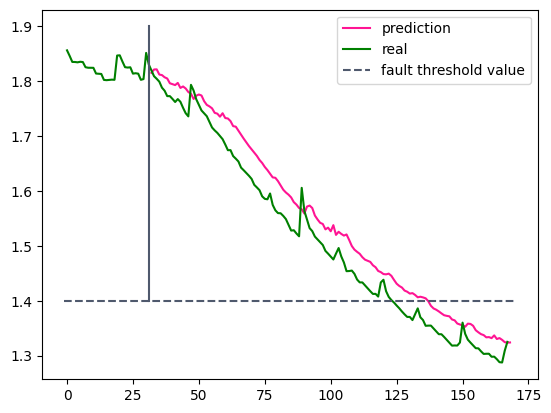

In [19]:
# plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
# plt.plot(ts, 'green', label='real')
# plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
# plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
# plt.legend(loc='best')

In [20]:
# txt = pred_test.tolist()
# txt

[1.8154889345169067,
 1.8215843439102173,
 1.8218421936035156,
 1.8123538494110107,
 1.8113869428634644,
 1.807412028312683,
 1.805145502090454,
 1.7964714765548706,
 1.7948806285858154,
 1.7931699752807617,
 1.797135591506958,
 1.7879765033721924,
 1.7906593084335327,
 1.7869447469711304,
 1.780522108078003,
 1.7773890495300293,
 1.767870306968689,
 1.773802638053894,
 1.7759817838668823,
 1.7741637229919434,
 1.7637771368026733,
 1.7570964097976685,
 1.7543509006500244,
 1.7507386207580566,
 1.7425482273101807,
 1.7410688400268555,
 1.7355549335479736,
 1.7418172359466553,
 1.7330749034881592,
 1.7322577238082886,
 1.7274715900421143,
 1.7183382511138916,
 1.717300295829773,
 1.7099409103393555,
 1.7024580240249634,
 1.6955039501190186,
 1.6886167526245117,
 1.6819446086883545,
 1.6760869026184082,
 1.6699213981628418,
 1.664067029953003,
 1.656609296798706,
 1.6511640548706055,
 1.6439003944396973,
 1.638183355331421,
 1.631474256515503,
 1.6248703002929688,
 1.624140977859497,
 1.6

In [26]:
model_params = {
    'input_size':   16,
    'output_size':  1,
    'num_channels': [128]*4,
    'kernel_size':  3,
    'dropout':      0.2
    }
look_back=16
lr=0.001
EPOCH=3900
seed=0
train_size=15
device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(model_params=model_params, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([15, 16, 1])
epoch:100 | loss:0.0012 | MAE:0.0380 | MSE:0.0016 | RMSE:0.0406 | R2:0.938 
epoch:200 | loss:0.0010 | MAE:0.0449 | MSE:0.0023 | RMSE:0.0475 | R2:0.915 
epoch:300 | loss:0.0006 | MAE:0.0443 | MSE:0.0022 | RMSE:0.0469 | R2:0.917 
epoch:400 | loss:0.0009 | MAE:0.0361 | MSE:0.0015 | RMSE:0.0386 | R2:0.944 
epoch:500 | loss:0.0007 | MAE:0.0394 | MSE:0.0018 | RMSE:0.0420 | R2:0.934 
epoch:600 | loss:0.0005 | MAE:0.0388 | MSE:0.0017 | RMSE:0.0413 | R2:0.936 
epoch:700 | loss:0.0006 | MAE:0.0443 | MSE:0.0022 | RMSE:0.0469 | R2:0.917 
epoch:800 | loss:0.0006 | MAE:0.0397 | MSE:0.0018 | RMSE:0.0423 | R2:0.933 
epoch:900 | loss:0.0004 | MAE:0.0434 | MSE:0.0021 | RMSE:0.0461 | R2:0.920 
epoch:1000 | loss:0.0003 | MAE:0.0382 | MSE:0.0017 | RMSE:0.0408 | R2:0.937 
epoch:1100 | loss:0.0004 | MAE:0.0354 | MSE:0.0014 | RMSE:0.0380 | R2:0.946 
epoch:1200 | loss:0.0005 | MAE:0.0416 | MSE:0.0020 | RMSE:0.0443 | R2:0.926 
epoch:1300 | loss:0.0005 | MAE:0.0442 | MSE:0.0

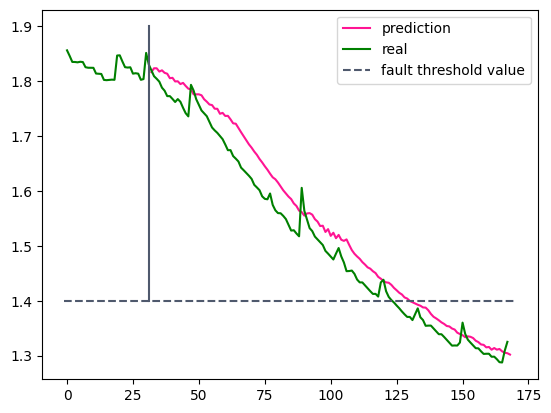

In [27]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [28]:
txt = pred_test.tolist()
txt

[1.8168902397155762,
 1.8238084316253662,
 1.8238141536712646,
 1.817795753479004,
 1.8200817108154297,
 1.8154797554016113,
 1.8138773441314697,
 1.8056899309158325,
 1.8063850402832031,
 1.7997872829437256,
 1.8001091480255127,
 1.7949910163879395,
 1.7971575260162354,
 1.7915717363357544,
 1.7865800857543945,
 1.7854052782058716,
 1.7762572765350342,
 1.7762953042984009,
 1.7763166427612305,
 1.77457857131958,
 1.7672548294067383,
 1.7629036903381348,
 1.7577794790267944,
 1.7566958665847778,
 1.7500728368759155,
 1.7499139308929443,
 1.7408305406570435,
 1.7424920797348022,
 1.736862063407898,
 1.7371078729629517,
 1.7307252883911133,
 1.723402738571167,
 1.7227544784545898,
 1.7149171829223633,
 1.7072570323944092,
 1.69974684715271,
 1.6923600435256958,
 1.6850097179412842,
 1.6790151596069336,
 1.671980619430542,
 1.6660268306732178,
 1.6584362983703613,
 1.6521804332733154,
 1.6452155113220215,
 1.638899326324463,
 1.6316566467285156,
 1.6250042915344238,
 1.6214935779571533,
 

In [9]:
# model_params = {
#     'input_size':   16,
#     'output_size':  1,
#     'num_channels': [128],
#     'kernel_size':  3,
#     'dropout':      0
#     }
# look_back=16
# lr=0.001
# EPOCH=4900
# seed=0
# train_size=15
# device = try_gpu(1)
# print("train on:",try_gpu(1))
# score_list, pred_test = train(model_params=model_params, look_back=look_back, 
#                                 lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cuda:1
torch.Size([15, 16, 1])
epoch:100 | loss:0.0004 | MAE:0.0499 | MSE:0.0027 | RMSE:0.0521 | R2:0.898 
epoch:200 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:300 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:400 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:500 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:600 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:700 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:800 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:900 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:1000 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:1100 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:1200 | loss:0.0003 | MAE:0.0466 | MSE:0.0024 | RMSE:0.0489 | R2:0.910 
epoch:1300 | loss:0.0003 | MAE:0.0466 | MSE:

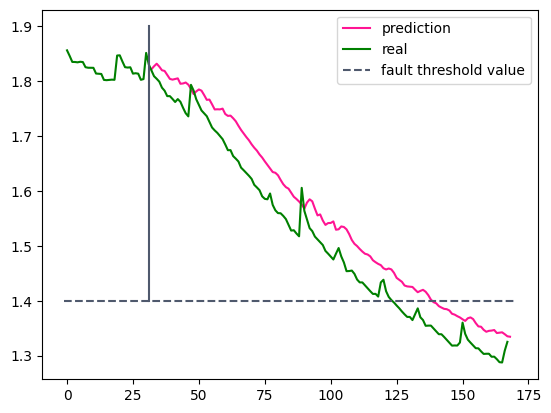

In [10]:
# plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
# plt.plot(ts, 'green', label='real')
# plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
# plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
# plt.legend(loc='best')

In [14]:
# model_params = {
#     'input_size':   16,
#     'output_size':  1,
#     'num_channels': [256],
#     'kernel_size':  3,
#     'dropout':      0
#     }
# look_back=16
# lr=0.001
# EPOCH=4700
# seed=0
# train_size=15
# device = try_gpu(1)
# print("train on:",try_gpu(1))
# score_list, pred_test = train(model_params=model_params, look_back=look_back, 
#                                 lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cuda:1
torch.Size([15, 16, 1])
epoch:100 | loss:0.0003 | MAE:0.0450 | MSE:0.0023 | RMSE:0.0479 | R2:0.914 
epoch:200 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:300 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:400 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:500 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:600 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:700 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:800 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:900 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0480 | R2:0.914 
epoch:1000 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0479 | R2:0.914 
epoch:1100 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0479 | R2:0.914 
epoch:1200 | loss:0.0003 | MAE:0.0451 | MSE:0.0023 | RMSE:0.0479 | R2:0.914 
epoch:1300 | loss:0.0003 | MAE:0.0452 | MSE:

In [17]:
# model_params = {
#     'input_size':   16,
#     'output_size':  1,
#     'num_channels': [256]*4,
#     'kernel_size':  3,
#     'dropout':      0
#     }
# look_back=16
# lr=0.001
# EPOCH=4700
# seed=0
# train_size=15
# device = try_gpu(10)
# print("train on:",try_gpu(10))
# score_list, pred_test = train(model_params=model_params, look_back=look_back, 
#                                 lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([15, 16, 1])
epoch:100 | loss:0.0003 | MAE:0.0613 | MSE:0.0041 | RMSE:0.0643 | R2:0.845 
epoch:200 | loss:0.0003 | MAE:0.0622 | MSE:0.0043 | RMSE:0.0652 | R2:0.840 
epoch:300 | loss:0.0003 | MAE:0.0623 | MSE:0.0043 | RMSE:0.0652 | R2:0.840 
epoch:400 | loss:0.0003 | MAE:0.0623 | MSE:0.0043 | RMSE:0.0652 | R2:0.840 
epoch:500 | loss:0.0003 | MAE:0.0623 | MSE:0.0043 | RMSE:0.0653 | R2:0.840 
epoch:600 | loss:0.0003 | MAE:0.0623 | MSE:0.0043 | RMSE:0.0653 | R2:0.840 
epoch:700 | loss:0.0003 | MAE:0.0624 | MSE:0.0043 | RMSE:0.0653 | R2:0.840 
epoch:800 | loss:0.0003 | MAE:0.0624 | MSE:0.0043 | RMSE:0.0653 | R2:0.839 
epoch:900 | loss:0.0003 | MAE:0.0624 | MSE:0.0043 | RMSE:0.0654 | R2:0.839 
epoch:1000 | loss:0.0003 | MAE:0.0625 | MSE:0.0043 | RMSE:0.0654 | R2:0.839 
epoch:1100 | loss:0.0003 | MAE:0.0625 | MSE:0.0043 | RMSE:0.0655 | R2:0.839 
epoch:1200 | loss:0.0003 | MAE:0.0625 | MSE:0.0043 | RMSE:0.0655 | R2:0.839 
epoch:1300 | loss:0.0003 | MAE:0.0626 | MSE:0.0

## 60

In [30]:
model_params = {
    'input_size':   16,
    'output_size':  1,
    'num_channels': [128]*4,
    'kernel_size':  3,
    'dropout':      0.2
    }
look_back=16
lr=0.001
EPOCH=1000
seed=0
train_size=45
device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(model_params=model_params, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([45, 16, 1])
epoch:100 | loss:0.0015 | MAE:0.0192 | MSE:0.0004 | RMSE:0.0211 | R2:0.965 
epoch:200 | loss:0.0013 | MAE:0.0284 | MSE:0.0009 | RMSE:0.0301 | R2:0.928 
epoch:300 | loss:0.0011 | MAE:0.0262 | MSE:0.0008 | RMSE:0.0279 | R2:0.938 
epoch:400 | loss:0.0008 | MAE:0.0212 | MSE:0.0005 | RMSE:0.0230 | R2:0.958 
epoch:500 | loss:0.0009 | MAE:0.0222 | MSE:0.0006 | RMSE:0.0240 | R2:0.954 
epoch:600 | loss:0.0007 | MAE:0.0199 | MSE:0.0005 | RMSE:0.0219 | R2:0.962 
epoch:700 | loss:0.0006 | MAE:0.0184 | MSE:0.0004 | RMSE:0.0206 | R2:0.966 
epoch:800 | loss:0.0006 | MAE:0.0183 | MSE:0.0004 | RMSE:0.0206 | R2:0.966 
epoch:900 | loss:0.0005 | MAE:0.0187 | MSE:0.0005 | RMSE:0.0213 | R2:0.964 
epoch:1000 | loss:0.0006 | MAE:0.0130 | MSE:0.0003 | RMSE:0.0168 | R2:0.978 


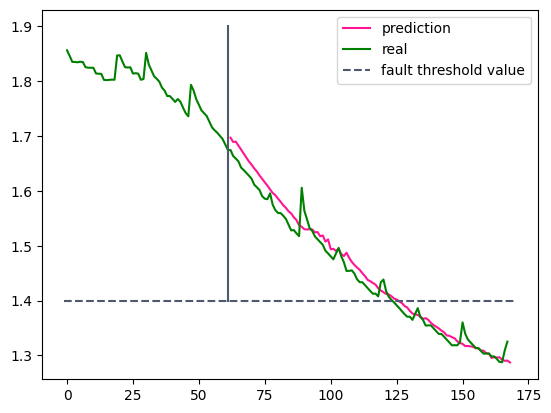

In [31]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [32]:
txt = pred_test.tolist()
txt

[1.6971510648727417,
 1.6893184185028076,
 1.6898465156555176,
 1.6826577186584473,
 1.675553560256958,
 1.6681134700775146,
 1.6608726978302002,
 1.6535518169403076,
 1.6477758884429932,
 1.6410818099975586,
 1.6354119777679443,
 1.6281259059906006,
 1.6220197677612305,
 1.6156429052352905,
 1.6095085144042969,
 1.6027731895446777,
 1.5961946249008179,
 1.5921046733856201,
 1.585932970046997,
 1.580146312713623,
 1.5738589763641357,
 1.569129228591919,
 1.5627861022949219,
 1.5590198040008545,
 1.5518683195114136,
 1.5470211505889893,
 1.5373812913894653,
 1.5345852375030518,
 1.530085802078247,
 1.5295946598052979,
 1.5302422046661377,
 1.529545783996582,
 1.5244710445404053,
 1.5249691009521484,
 1.5172488689422607,
 1.5186896324157715,
 1.5074918270111084,
 1.5115363597869873,
 1.4935083389282227,
 1.4943428039550781,
 1.4904627799987793,
 1.4943296909332275,
 1.4845960140228271,
 1.481201171875,
 1.4871950149536133,
 1.4778647422790527,
 1.4704320430755615,
 1.4649577140808105,
 1

## 90

In [36]:
model_params = {
    'input_size':   16,
    'output_size':  1,
    'num_channels': [128]*4,
    'kernel_size':  3,
    'dropout':      0.2
    }
look_back=16
lr=0.001
EPOCH=4900
seed=0
train_size=75
device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(model_params=model_params, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([75, 16, 1])
epoch:100 | loss:0.0017 | MAE:0.0098 | MSE:0.0001 | RMSE:0.0121 | R2:0.971 
epoch:200 | loss:0.0015 | MAE:0.0124 | MSE:0.0002 | RMSE:0.0142 | R2:0.960 
epoch:300 | loss:0.0013 | MAE:0.0093 | MSE:0.0001 | RMSE:0.0121 | R2:0.971 
epoch:400 | loss:0.0008 | MAE:0.0102 | MSE:0.0002 | RMSE:0.0149 | R2:0.955 
epoch:500 | loss:0.0009 | MAE:0.0145 | MSE:0.0004 | RMSE:0.0189 | R2:0.929 
epoch:600 | loss:0.0007 | MAE:0.0169 | MSE:0.0004 | RMSE:0.0209 | R2:0.912 
epoch:700 | loss:0.0006 | MAE:0.0263 | MSE:0.0009 | RMSE:0.0292 | R2:0.830 
epoch:800 | loss:0.0005 | MAE:0.0262 | MSE:0.0008 | RMSE:0.0291 | R2:0.831 
epoch:900 | loss:0.0005 | MAE:0.0246 | MSE:0.0008 | RMSE:0.0276 | R2:0.847 
epoch:1000 | loss:0.0005 | MAE:0.0278 | MSE:0.0009 | RMSE:0.0305 | R2:0.814 
epoch:1100 | loss:0.0005 | MAE:0.0232 | MSE:0.0007 | RMSE:0.0264 | R2:0.861 
epoch:1200 | loss:0.0004 | MAE:0.0195 | MSE:0.0005 | RMSE:0.0232 | R2:0.892 
epoch:1300 | loss:0.0004 | MAE:0.0203 | MSE:0.0

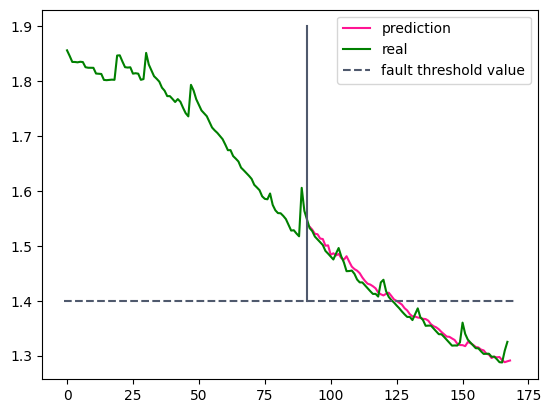

In [37]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [38]:
txt = pred_test.tolist()
txt

[1.5349655151367188,
 1.52960205078125,
 1.5220460891723633,
 1.521237850189209,
 1.5133754014968872,
 1.5125000476837158,
 1.500321388244629,
 1.5010426044464111,
 1.4837627410888672,
 1.4865413904190063,
 1.4824812412261963,
 1.4852964878082275,
 1.477820634841919,
 1.474873661994934,
 1.4811513423919678,
 1.4713512659072876,
 1.4621975421905518,
 1.4576826095581055,
 1.4548423290252686,
 1.4501945972442627,
 1.4423723220825195,
 1.436097502708435,
 1.431032419204712,
 1.4295015335083008,
 1.4264217615127563,
 1.4226754903793335,
 1.4150843620300293,
 1.4117848873138428,
 1.409697413444519,
 1.4126049280166626,
 1.4146820306777954,
 1.4086995124816895,
 1.4023960828781128,
 1.3996491432189941,
 1.3964005708694458,
 1.3929412364959717,
 1.386469841003418,
 1.3823282718658447,
 1.3755053281784058,
 1.3715333938598633,
 1.3711740970611572,
 1.3694288730621338,
 1.3688304424285889,
 1.3669990301132202,
 1.3666008710861206,
 1.3636784553527832,
 1.3572185039520264,
 1.3536510467529297,
 1